# CHANGEPOINT DETECTION DETECTING CHANGES IN MEAN IN R

Welcome to our new series about *changepoint detection*, sometimes also called *changepoint analysis*. In this series we want to explain how a changepoint can be detected using **standard packages in R**.

A brief introduction to changepoint analysis can be found in our introduction blog (see https://github.com/cschroth2/Changepoint-Analysis where we used python code). In this blog, we want to focus on *changes in mean* only.

Let's define the libraries we will need.

In [1]:
required_packages <- c('changepoint','ggplot2','repr')

Let's read the libraries we will need (you can safely ignore the warnings when you use R.4.0):

In [2]:
for (package in required_packages){ 
  if (!require(package, character.only = TRUE, quietly = TRUE)) {
    install.packages(package, repos='http://cran.us.r-project.org', dependencies = TRUE)
    library(package, character.only = TRUE)
  }
}
options(repr.plot.width=6, repr.plot.height=4) # plot options

Warning message:
"package 'changepoint' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.
Warning message:
"package 'ggplot2' was built under R version 3.6.3"

## 1) Create an example

Let's consider the following example. We define a signal with length $1200$ and two changepoints at $400$ and $900$.

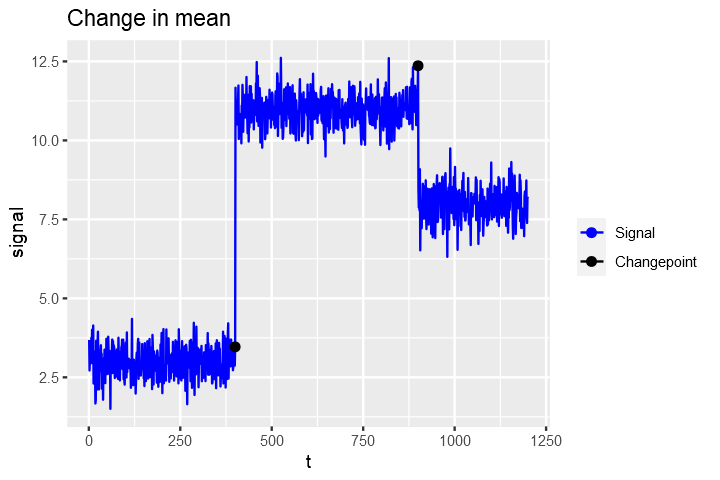

In [3]:
signal_length <- 1200
my_changepoints <- c(400,900)
set.seed(42) # comment to obtain slightly different signals

###########################################
# create the signal

my_std = 0.5
signal <- rnorm(my_changepoints[1],3,my_std)
signal <- c(signal,rnorm(my_changepoints[2]-my_changepoints[1],11,my_std))
signal <- c(signal,rnorm(signal_length-my_changepoints[2],8,my_std))
# extend vector to dataframe
t = seq(1,length(signal))
signal2 <- data.frame(t,signal)
# add column with changepoint values
signal2$MyChangePoint <- NA
for (i in 1:length(my_changepoints)){
  signal2[my_changepoints[i], "MyChangePoint"] <- signal2[my_changepoints[i], "signal"]
}
# the actual plot
ggplot() + ggtitle("Change in mean") +
  geom_line(data = signal2, aes(x = t, y = signal, color = "blue")) +
  geom_point(data = na.omit(signal2), aes(x = t, y = MyChangePoint, color = "black"), size = 2) +
  scale_color_identity(name = "",
                       breaks = c("blue", "black"),
                       labels = c("Signal", "Changepoint"),
                       guide = "legend")

## 2) Brief introduction to the R changepoint package

The R *changepoint* package (https://cran.r-project.org/web/packages/changepoint/index.html ) is probably *the* standard library for changepoint detection in R. The core is implemented in C++ and therefore the package is very runtime efficient. It also has several hyperparameters to tune the algorithms. In case you need to tune the algorithms we recommend to study the manual from the package (see link above) to get more information about optional hyperparameters.

A more detailed introduction to the package can be found in (Killick and Eckley, 2014), the formal theory behind it can be found in  (Killick et al., 2012).

Basically, we have similar ideas as described in our [previous blog](./CP-detection2-runtime-aspects.ipynb), therefore we just run the code and consider the results.

### The PELT method

The *PELT method* (PELT=Pruned Exact Linear Time) became famous for its theoretical runtime: if $T$ denotes the length of the signal then the **expected** runtime is $\mathcal{O}(T)$, however the **worst case** runtime can be $\mathcal{O}(T^2)$. To put it simply, the (expected) runtime is linear which makes the PELT algorithm one of the fastest algorithms in changepoint detection.

Note, that we do not provide the information that we have two changepoints. But we provide the constraint *pen.value*. Let's try it out and consider the result:

In [4]:
# cpt.mean(): we want to detect changes in mean
# "PELT": use the binary segmentation method
# pen.value: penalty value >0
tmp <- cpt.mean(signal,method="PELT",pen.value=1,test.stat="Normal")
# extract changepoints
my_bkps <- tmp@cpts
# delete last element in list (last point of the signal is always treatet as changepoint)
my_bkps <- head(my_bkps, -1)
print('Detected changepoints:')
print(my_bkps)

[1] "Detected changepoints:"
[1] 400 900


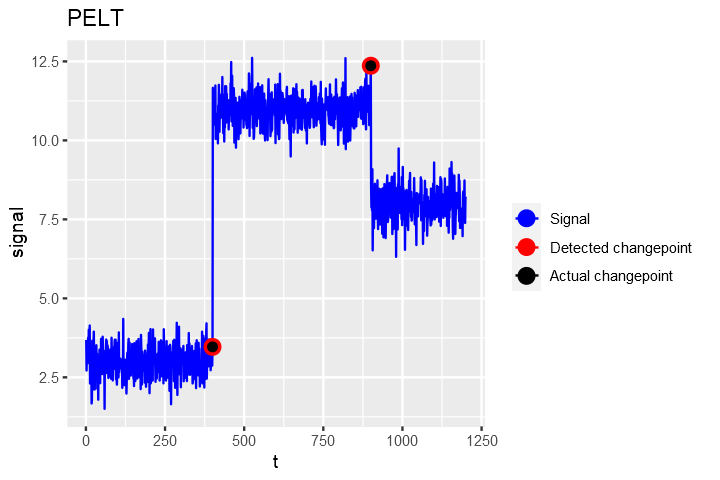

In [5]:
# extract changepoints and plot the detected changepoints
signal2$DetectedChangePoints <- NA
for (i in 1:length(my_bkps)){
  signal2[my_bkps[i], "DetectedChangePoints"] <- signal2[my_bkps[i], "signal"]
}
ggplot() + ggtitle("PELT") + 
  geom_line(data = signal2, aes(x = t, y = signal, color = "blue")) +
  geom_point(data = na.omit(signal2), aes(x = t, y = DetectedChangePoints, color = "red"), size = 4) +
  geom_point(data = na.omit(signal2), aes(x = t, y = MyChangePoint, color = "black"), size = 2) +
  
  scale_color_identity(name = "",
                       breaks = c("blue", "red", "black"),
                       labels = c("Signal", "Detected changepoint","Actual changepoint"),
                       guide = "legend")

### The Binary segmentation method

The *binary segmentation method* is a well established method in changepoint analysis. Let's calculate and plot the changepoints that are detected by the binary segmentation.

In [6]:
# cpt.mean(): we want to detect changes in mean
# "BinSeg": use the binary segmentation method
# Q: number of expected changepoints in signal
tmp <- cpt.mean(signal,method="BinSeg",Q=2);
# extract changepoints
my_bkps <- tmp@cpts
# delete last element in list (last point of the signal is always interpreted as changepoint)
my_bkps <- head(my_bkps, -1)
print('Detected changepoints:')
print(my_bkps)

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
"The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed."

[1] "Detected changepoints:"
[1] 400 900


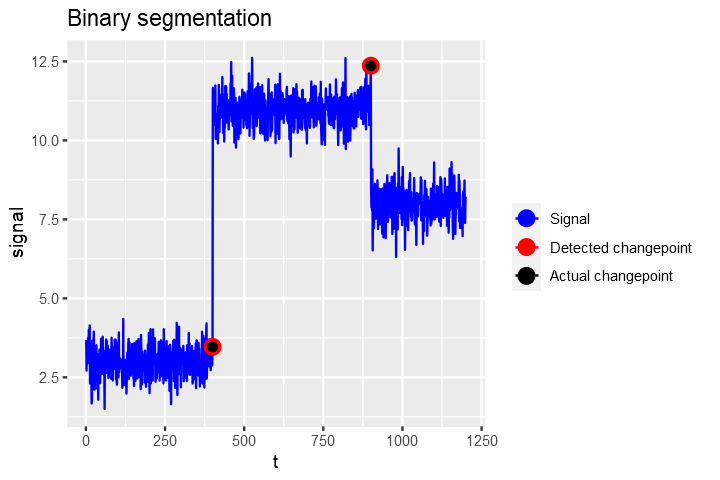

In [7]:
# extract changepoints and plot the detected changepoints
signal2$DetectedChangePoints <- NA
for (i in 1:length(my_bkps)){
  signal2[my_bkps[i], "DetectedChangePoints"] <- signal2[my_bkps[i], "signal"]
}
ggplot() + ggtitle("Binary segmentation") + 
  geom_line(data = signal2, aes(x = t, y = signal, color = "blue")) +
  geom_point(data = na.omit(signal2), aes(x = t, y = DetectedChangePoints, color = "red"), size = 4) +
  geom_point(data = na.omit(signal2), aes(x = t, y = MyChangePoint, color = "black"), size = 2) +
  
  scale_color_identity(name = "",
                       breaks = c("blue", "red", "black"),
                       labels = c("Signal", "Detected changepoint","Actual changepoint"),
                       guide = "legend")

## 3) Self optimizing changepoint detection

You may have noticed the warning message above. This shows that the R *changepoint* package has a remarkable property: the package is self optimizing in a sense that it delivers the optimized number of changepoints automatically.

To show what this means we consider the signal above wich has two changepoints. If we provide $Q=6$ to the algorithm then it will *still* identify only two changepoints. Let's see how it works:

In [8]:
# cpt.mean(): we want to detect changes in mean
# "BinSeg": use the binary segmentation method
# Q: number of expected changepoints in signal
tmp <- cpt.mean(signal,method="BinSeg",Q=6)
# extract changepoints
my_bkps <- tmp@cpts
# delete last element in list (last point of the signal is always interpreted as changepoint)
my_bkps <- head(my_bkps, -1)
print('Detected changepoints:')
print(my_bkps)

[1] "Detected changepoints:"
[1] 400 900


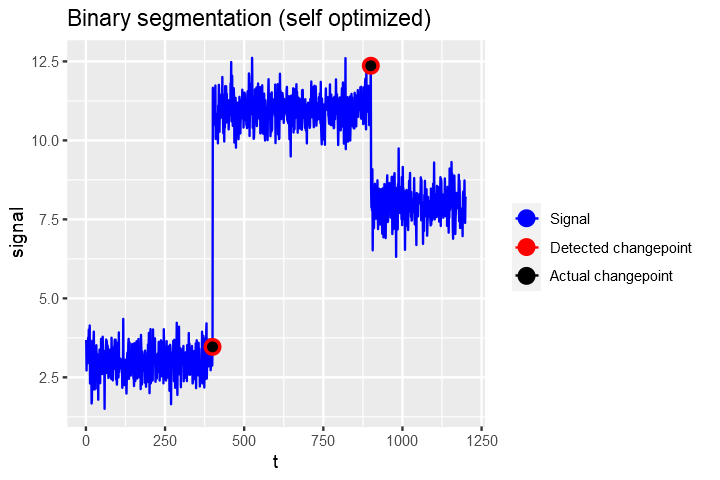

In [9]:
# extract changepoints and plot the detected changepoints
signal2$DetectedChangePoints <- NA
for (i in 1:length(my_bkps)){
  signal2[my_bkps[i], "DetectedChangePoints"] <- signal2[my_bkps[i], "signal"]
}
ggplot() + ggtitle("Binary segmentation (self optimized)") + 
  geom_line(data = signal2, aes(x = t, y = signal, color = "blue")) +
  geom_point(data = na.omit(signal2), aes(x = t, y = DetectedChangePoints, color = "red"), size = 4) +
  geom_point(data = na.omit(signal2), aes(x = t, y = MyChangePoint, color = "black"), size = 2) +
  
  scale_color_identity(name = "",
                       breaks = c("blue", "red", "black"),
                       labels = c("Signal", "Detected changepoint","Actual changepoint"),
                       guide = "legend")

Indeed, we required $Q=6$ changepoints and obtained only two. Apart from that, we have no longer a warning message.

In a more realistic setup it could be the case that we require, for example, three changepoints but we obtain only two. For this case the algorithm stores all required changepoints in the background. In other words, in case you want to force the algorithm to discover $Q=6$ changepoints all of them are calculated.

Let's briefly consider how all $Q=6$ required changepoints can be extracted:

In [10]:
print(tmp@cpts.full)

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]  400   NA   NA   NA   NA   NA
[2,]  400  900   NA   NA   NA   NA
[3,]  400  900  899   NA   NA   NA
[4,]  400  900  899  898   NA   NA
[5,]  400  900  899  898  399   NA
[6,]  400  900  899  898  399  398


Obviously, the last row represents the $Q=6$ changepoints. These values do not make much sense in our example because they are all located around the real changepoints. It looks like it was not too wrong that the algorithm delivered only two changepoints automatically.

## 4) Discussion

We have seen two methods that are able to identify changes in mean. The methods are implemented in a way that they deliver the optimal number of changepoints. Also, more changepoints can are calculated in case that the optimized number of changepoints is too small.

Nevertheless, the methods are very basic and the *changepoint* package may not be able to deal with more complex changes. Also, we covered changes in mean only, it is still unclear if the presented methods will work for other changes.

### Summary

Let's summarize the advantages and shortcomings of the *changepoint* package:

**Advantages:**

- easy to apply
- many hyperparameters that can be applied (note, that we haven't presented them in this blog)
- detection of changes in mean possible
- short runtime because the core is written in C++
- delivers optimized numbers of changepoints automatically.

**Shortcomings:**

- basic algorithms (unclear, if more compicated changes can be detected)
- choice of the method and hyperparameters not always straightforward.

## 5) Literature

- Killick, Rebecca, Paul Fearnhead, and Idris A. Eckley. "Optimal detection of changepoints with a linear computational cost." Journal of the American Statistical Association 107.500 (2012): 1590-1598.
- Killick, Rebecca, and Idris Eckley. "changepoint: An R package for changepoint analysis." Journal of statistical software 58.3 (2014): 1-19.